##### Groupe : HSIA Celia ; MICONNET Sandrine ; TILLACOVINDARADJANE Mélanie

# <center>Projet Natural Language Processing</center>
<center><span style="font-weight: bold; font-size: 1.8rem;">Topic Modeling</span></center>

*Sujet :*
    Le Topic Modeling est un sous-champ du Natural Language Processing visant à extraire les sujets de discussions principaux d’un corpus de texte. On appelle un sujet de discussion un groupe de mots ou un groupe de phrases partageant une thématique spécifique. 
    Dans le cadre de ce projet, nous travaillerons sur le jeu de données News Category Dataset contenant 200K headlines de journaux en anglais. 
    
L’objectif de ce projet est d’étudier les performances d’algorithmes de Topic Modeling sur les données mentionnées ci-avant. Pour ce faire, vous devrez :  
 - 1) Analyser le corpus de texte pour en extraire ses caractéristiques spécifiques (taille moyenne, types de mots utilisés, mots les plus fréquents, stopwords, etc.). 
 - 2) Sélectionner 2 méthodologies de Topic Modeling / Clustering vous semblant en phase avec les données à traiter  
 - 3) Définir une ou plusieurs métriques permettant de mesurer la qualité de vos modèles  
        Note : vous pouvez utiliser les catégories des headlines fournies dans le jeu de données. Cependant, il s’agit ici d’un problème de clustering avant tout, il faut donc que vous mettiez également en avant des métriques prenant en compte cela.   
 - 4) Réaliser les tests comparatifs de chacun des modèles que vous avez sélectionné  
 - 5) Conclure sur la meilleure méthodologie à utiliser dans votre cas et préciser les pistes d’améliorations de votre analyse  

### 1) Analyse de texte

#### Mise en place de l'environnement de travail

In [47]:
#importation des bibliothèques nécessaires
import itertools
import os
import re
import secrets
import string
import gensim

import pandas as pd
import numpy as np
import spacy

from itertools import chain
from matplotlib import pyplot as plt


from gensim.models import CoherenceModel
from gensim.models.callbacks import CallbackAny2Vec
from gensim.models import Word2Vec, Phrases, KeyedVectors
from gensim.models.phrases import Phraser
from gensim.utils import simple_preprocess

import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk.corpus import wordnet
# from pattern.en import pluralize, singularize
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm

from spacy.parts_of_speech import IDS as POS_map
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import pyLDAvis.gensim_models
import umap.umap_ as umap

In [2]:
#loader le dataset
dataset = pd.read_json("News_Category_Dataset_v3.json", lines=True, dtype={"headline": str})

#permet de travailler avec une partie du dataset si l'on veut gagner du temps
#dataset = dataset.head(1000)

#### Début de l'analyse

In [3]:
#fonction qui identifie les mots dans une phrase ( façon simple et non optimisée)
def dummy_word_split(texts):
    texts_out = []
    for text in texts:
        texts_out.append(text.split(" "))
    #return = list of list containing each word separately   
    return texts_out
splitted_texts = dummy_word_split(dataset["headline"].tolist())
splitted_texts[209526]

['Dwight',
 'Howard',
 'Rips',
 'Teammates',
 'After',
 'Magic',
 'Loss',
 'To',
 'Hornets']

In [4]:
# nombre moyen général du nombre de mots dans les titres du corpus de textes
for i in range(len(splitted_texts)):
    testtext =np.mean(len(splitted_texts[i]))
print("La taille moyenne des titres dans ce corpus est de",np.mean(testtext),"mots")

La taille moyenne des titres dans ce corpus est de 9.0 mots


In [5]:
print("Le nombre total de textes dans ce corpus est de",len(splitted_texts),"titres uniques")

Le nombre total de textes dans ce corpus est de 209527 titres uniques


#### Comptages des mots les plus fréquents

In [6]:
def compute_word_occurences(texts):
    #compute_word_occurences=splitted_texts.count().unique()
    words = itertools.chain.from_iterable(texts)
    
    word_count = pd.Series(words).value_counts()
    word_count = pd.DataFrame({"Word": word_count.index, "Count": word_count.values})

    return word_count

compute_word_occurences(splitted_texts).head(50)

,Word,Count
0,The,49249
1,To,41132
2,In,25941
3,A,25704
4,Of,24393
5,For,20042
6,Is,17365
7,And,15827
8,On,14663
9,With,13222


In [7]:
print("Le nombre total de mots différents dans ce corpus de texte est de",len(compute_word_occurences(splitted_texts)),"avant traitement.")

Le nombre total de mots différents dans ce corpus de texte est de 123269 avant traitement.


#### Data quality

In [8]:
#on regarde le type des données d'entrées pour voir s'il y a des formats différents de string et s'il y a des données manquantes
def check_data_quality(texts):
    #si les données d'entrées sont différentes de strings
    assert all([isinstance(t, str) for t in texts])
    #si les données d'entrées contiennent des NaN
    assert all([t != np.nan for t in texts])
    
    return True

def force_format(texts):
    return [str(t) for t in texts]

In [9]:
texts = force_format(dataset["headline"])
print(f"Is the dataset passing our data quality check?\n{check_data_quality(texts)}")

Is the dataset passing our data quality check?
True


In [10]:
# permet de retirer les parties incorrectes des textes téléchargés comme les mises en formes et hyperlinks
def filter_text(texts_in):
    texts_out = re.sub(r'https?:\/\/[A-Za-z0-9_.-~\-]*', ' ', texts_in, flags=re.MULTILINE) #hyperlinks
    texts_out = re.sub(r'[(){}\[\]<>]', ' ', texts_out, flags=re.MULTILINE) #ponctuation
    texts_out = re.sub(r'&amp;#.*;', ' ', texts_out, flags=re.MULTILINE) 
    texts_out = re.sub(r'&gt;', ' ', texts_out, flags=re.MULTILINE)
    texts_out = re.sub(r'â€™', "'", texts_out, flags=re.MULTILINE)
    texts_out = re.sub(r'\s+', ' ', texts_out, flags=re.MULTILINE)
    texts_out = re.sub(r'&#x200B;', ' ', texts_out, flags=re.MULTILINE)
    texts_out = re.sub(r'[a-zA-Z0-9-_.]+@[a-zA-Z0-9-_.]+\.[a-zA-Z0-9-_.]+', '', texts_out, flags=re.MULTILINE) # Mail
    texts_out = re.sub(r"\(?\d{3}\D{0,3}\d{3}\D{0,3}\d{4}", '', texts_out, flags=re.MULTILINE) # Phone
    texts_out = re.sub(r'@\S+( |\n)', '', texts_out, flags=re.MULTILINE) # Retire les tags de noms si twitter est cité
    texts_out = re.sub(r'\*', '', texts_out, flags=re.MULTILINE) #retire les tags de noms sur les réseaux sociaux sont cités
    
    return texts_out

texts = [filter_text(t) for t in texts]

In [11]:
#ici on convertit les phrases en listes de mots
def sent_to_words(sentences):
    for sentence in tqdm(sentences):
        yield (simple_preprocess(str(sentence), deacc=True))
        
texts = list(sent_to_words(texts))

100%|███████████████████████████████████████████████████████████████████████| 209527/209527 [00:18<00:00, 11432.48it/s]


In [12]:
#ce qu'on obtient après traitement des phrases en listes
texts[0] + texts[1]

['over',
 'million',
 'americans',
 'roll',
 'up',
 'sleeves',
 'for',
 'omicron',
 'targeted',
 'covid',
 'boosters',
 'american',
 'airlines',
 'flyer',
 'charged',
 'banned',
 'for',
 'life',
 'after',
 'punching',
 'flight',
 'attendant',
 'on',
 'video']

#### Gestion des stopwords

In [13]:
#quels sont donc les stopwords que l'on peut rencontrés dans notre corpus
def get_stopwords(additional_stopwords=[]):
    # Loading standard english stop words
    with open('stopwords.txt', 'r') as f:
        stop_w = f.readlines()
    stopwords = [s.rstrip() for s in stop_w]

    # Adding stop words from sklearn
    stopwords = list(text.ENGLISH_STOP_WORDS.union(stopwords))

    # Adding words from a list if specified
    if additional_stopwords:
        stopwords += additional_stopwords

    # Removing duplicates
    stopwords = list(set(stopwords))

    # Removing some \n that were included in the native stopwords of sklearn ... WHY?
    stopwords = [s.replace("\n", "") for s in stopwords]

    stopwords = sorted(stopwords, key=str.lower)

    return stopwords

stopwords = get_stopwords(additional_stopwords=[]) #on n'ajoute pas de stopwords à la liste que l'on possède déjà
stopwords

['a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'amoungst',
 'amount',
 'an',
 'and',
 'another',
 'any',
 'anybody',
 'anyhow',
 'anyone',
 'anything',
 'anyway',
 'anywhere',
 'are',
 'area',
 'areas',
 'around',
 'as',
 'ask',
 'asked',
 'asking',
 'asks',
 'at',
 'away',
 'b',
 'back',
 'backed',
 'backing',
 'backs',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'began',
 'behind',
 'being',
 'beings',
 'below',
 'beside',
 'besides',
 'best',
 'better',
 'between',
 'beyond',
 'big',
 'bill',
 'both',
 'bottom',
 'but',
 'by',
 'c',
 'call',
 'came',
 'can',
 'cannot',
 'cant',
 'case',
 'cases',
 'certain',
 'certainly',
 'clear',
 'clearly',
 'co',
 'come',
 'con',
 'could',
 'couldnt',
 'cry',
 'd',
 'de',
 'describe',
 'detail',
 'did',
 'differ',
 'different',
 'differentl

In [14]:
#on récupère la liste des titres sans les stopwords
texts = [[word for word in txt if word not in stopwords] for txt in tqdm(texts)]
texts

100%|████████████████████████████████████████████████████████████████████████| 209527/209527 [00:30<00:00, 6940.85it/s]


[['million',
  'americans',
  'roll',
  'sleeves',
  'omicron',
  'targeted',
  'covid',
  'boosters'],
 ['american',
  'airlines',
  'flyer',
  'charged',
  'banned',
  'life',
  'punching',
  'flight',
  'attendant',
  'video'],
 ['funniest', 'tweets', 'cats', 'dogs', 'week', 'sept'],
 ['funniest', 'tweets', 'parents', 'week', 'sept'],
 ['woman',
  'called',
  'cops',
  'black',
  'bird',
  'watcher',
  'loses',
  'lawsuit',
  'ex',
  'employer'],
 ['cleaner', 'dead', 'belk', 'bathroom', 'days', 'body', 'police'],
 ['reporter', 'adorable', 'surprise', 'boyfriend', 'live', 'tv'],
 ['puerto', 'ricans', 'desperate', 'water', 'hurricane', 'fiona', 'rampage'],
 ['documentary', 'captures', 'complexity', 'child', 'immigrants'],
 ['biden', 'russian', 'war', 'affront', 'body', 'charter'],
 ['world', 'cup', 'captains', 'wear', 'rainbow', 'armbands', 'qatar'],
 ['sets', 'apparent', 'protest', 'funeral', 'japan', 'abe'],
 ['fiona', 'threatens', 'category', 'storm', 'headed', 'bermuda'],
 ['twitc

#### Analyse après traitement du corpus de textes

In [15]:
#on regarde quels sont les mots les plus représentés lorsque les stopwords sont retirés
compute_word_occurences(texts).head(50)

,Word,Count
0,trump,14370
1,photos,10373
2,video,5942
3,donald,4849
4,day,4683
5,women,3512
6,world,3434
7,life,3073
8,people,3052
9,week,2823


In [16]:
#il y a une sureprésentation du nom Trump et cela fausse les conclusions suivantes
stopwords = get_stopwords(additional_stopwords=["trump","jan","ex"])
stopwords

['a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'amoungst',
 'amount',
 'an',
 'and',
 'another',
 'any',
 'anybody',
 'anyhow',
 'anyone',
 'anything',
 'anyway',
 'anywhere',
 'are',
 'area',
 'areas',
 'around',
 'as',
 'ask',
 'asked',
 'asking',
 'asks',
 'at',
 'away',
 'b',
 'back',
 'backed',
 'backing',
 'backs',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'began',
 'behind',
 'being',
 'beings',
 'below',
 'beside',
 'besides',
 'best',
 'better',
 'between',
 'beyond',
 'big',
 'bill',
 'both',
 'bottom',
 'but',
 'by',
 'c',
 'call',
 'came',
 'can',
 'cannot',
 'cant',
 'case',
 'cases',
 'certain',
 'certainly',
 'clear',
 'clearly',
 'co',
 'come',
 'con',
 'could',
 'couldnt',
 'cry',
 'd',
 'de',
 'describe',
 'detail',
 'did',
 'differ',
 'different',
 'differentl

In [17]:
#on récupère la liste des titres sans les stopwords
texts = [[word for word in txt if word not in stopwords] for txt in tqdm(texts)]
texts

100%|████████████████████████████████████████████████████████████████████████| 209527/209527 [00:22<00:00, 9255.67it/s]


[['million',
  'americans',
  'roll',
  'sleeves',
  'omicron',
  'targeted',
  'covid',
  'boosters'],
 ['american',
  'airlines',
  'flyer',
  'charged',
  'banned',
  'life',
  'punching',
  'flight',
  'attendant',
  'video'],
 ['funniest', 'tweets', 'cats', 'dogs', 'week', 'sept'],
 ['funniest', 'tweets', 'parents', 'week', 'sept'],
 ['woman',
  'called',
  'cops',
  'black',
  'bird',
  'watcher',
  'loses',
  'lawsuit',
  'employer'],
 ['cleaner', 'dead', 'belk', 'bathroom', 'days', 'body', 'police'],
 ['reporter', 'adorable', 'surprise', 'boyfriend', 'live', 'tv'],
 ['puerto', 'ricans', 'desperate', 'water', 'hurricane', 'fiona', 'rampage'],
 ['documentary', 'captures', 'complexity', 'child', 'immigrants'],
 ['biden', 'russian', 'war', 'affront', 'body', 'charter'],
 ['world', 'cup', 'captains', 'wear', 'rainbow', 'armbands', 'qatar'],
 ['sets', 'apparent', 'protest', 'funeral', 'japan', 'abe'],
 ['fiona', 'threatens', 'category', 'storm', 'headed', 'bermuda'],
 ['twitch', 'ban

In [18]:
#on regarde quels sont les mots les plus représentés lorsque les stopwords sont retirés
compute_word_occurences(texts).head(50)

,Word,Count
0,photos,10373
1,video,5942
2,donald,4849
3,day,4683
4,women,3512
5,world,3434
6,life,3073
7,people,3052
8,week,2823
9,time,2794


In [19]:
#le nombre de titres après le traitement
print("Le nombre total de textes dans ce corpus est de",len(texts),"titres uniques après traitement des stopwords.")

Le nombre total de textes dans ce corpus est de 209527 titres uniques après traitement des stopwords.


In [20]:
#taille moyenne des titres après traitement
for i in range(len(texts)):
    testtext_ss =np.mean(len(texts[i]))
print("La taille moyenne des titres dans ce corpus est de",np.mean(testtext_ss),"mots après traitement des stopwords.")

La taille moyenne des titres dans ce corpus est de 7.0 mots après traitement des stopwords.


### Biterm topic modeling : nos textes sont courts

In [21]:
#création de bi-grams et identification dans le texte
def create_bigrams(texts, bigram_count=15, threshold=10, convert_sent_to_words=False, as_str=True):
    if convert_sent_to_words:
        texts = list(sent_to_words(texts))
    
    bigram_model = Phraser(Phrases(texts, min_count=bigram_count, threshold=threshold))
    
    if as_str:
        return [" ".join(bigram_model[t]) for t in texts]

    else:
        return [bigram_model[t] for t in texts]

texts = create_bigrams(texts)
texts

['million americans roll sleeves omicron targeted covid boosters',
 'american_airlines flyer charged banned life punching flight_attendant video',
 'funniest_tweets cats_dogs week sept',
 'funniest_tweets parents_week sept',
 'woman called cops black bird watcher loses lawsuit employer',
 'cleaner dead belk bathroom days body police',
 'reporter adorable surprise boyfriend live_tv',
 'puerto ricans desperate water hurricane fiona rampage',
 'documentary captures complexity child immigrants',
 'biden russian war affront body charter',
 'world_cup captains wear rainbow armbands qatar',
 'sets apparent protest funeral japan abe',
 'fiona threatens category storm headed bermuda',
 'twitch bans gambling sites streamer scams folks',
 'virginia thomas agrees interview panel',
 'russian cosmonaut valery polyakov broke record day stay space dies',
 'reboot clever navel gazey look inside tv reboots',
 'maury wills base stealing shortstop dodgers dies',
 'russian controlled ukrainian regions sche

In [22]:
#création de tri-gram si besoin et retour de textes avec des trigrams
#def create_trigrams(texts, trigram_count=15, threshold=10, convert_sent_to_words=False, as_str=True):
#    if convert_sent_to_words:
#        texts = list(sent_to_words(texts))
    
#    bigram_model = Phraser(Phrases(texts, min_count=bigram_count, threshold=threshold))    
#    if as_str:
#        return [" ".join(bigram_model[t]) for t in texts]

#    else:
#        return [bigram_model[t] for t in texts]

In [23]:
# lemmatisation = opération de mettre les mots sous leur forme canonique
def lemmatize_texts(texts, 
                    allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'], 
                    forbidden_postags=[], 
                    as_sentence=False, 
                    get_postags=False, 
                    spacy_model=None):
    texts_out = []
    
    if allowed_postags and forbidden_postags:
        raise ValueError("Can't specify both allowed and forbidden postags")

    if forbidden_postags:
        allowed_postags = list(set(POS_map.keys()).difference(set(forbidden_postags)))

    if not spacy_model:
        print("Loading spacy model")
        spacy_model = spacy.load('en_core_web_md')

    print("Beginning lemmatization process")
    total_steps = len(texts)

    docs = spacy_model.pipe(texts)

    for i, doc in tqdm(enumerate(docs), total=total_steps):
        if get_postags:
            texts_out.append(["_".join([token.lemma_, token.pos_]) for token in doc if token.pos_ in allowed_postags])
        else:
            texts_out.append(
                [token.lemma_ for token in doc if token.pos_ in allowed_postags])
    
    if as_sentence:
        texts_out = [" ".join(text) for text in texts_out]
        
    return texts_out

In [24]:
l_texts = lemmatize_texts(texts[:1000],
                allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV', 'X', 'PROPN'], 
                get_postags=False)

Loading spacy model
Beginning lemmatization process


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 284.50it/s]


In [25]:
occurences = compute_word_occurences(l_texts)
occurences

,Word,Count
0,ukraine,40
1,russian,34
2,biden,27
3,woman,25
4,win,22
...,...,...
3273,gored,1
3274,parlor,1
3275,vietnam,1
3276,swim,1


In [26]:
occurences.head(50)

,Word,Count
0,ukraine,40
1,russian,34
2,biden,27
3,woman,25
4,win,22
5,covid,22
6,kill,21
7,abortion,19
8,day,19
9,official,19


*Conclusion de la partie d'analyse* :

On remarque que notre dataset est assez grand puisqu'il est composé de plus de 200 000 titres de journaux axé sur les informations américaines. Ces titres sont principalement composés de noms communs et de noms propres après la gestion des mots de liaisons et des "stopwords". D'ailleurs, la taille moyenne des titres est de 9 mots mais lorsqu'on retire les stopwords, cette taille moyenne passe à 7 mots. 
Après comptage, nous voyons que les mots les plus représentés sont des mots de liaisons:
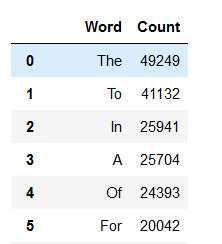
Il nous faut alors les retirer afin de garder seulement les mots importants qui pourront influencer notre Topic Modeling. Pour cela, nous avons retirer la ponctuation et les caractères spéciaux pour se concentrer uniquement sur les mots. De là, nous avons télécharger la liste des stopwords en anglais afin de pouvoir les supprimer de notre liste de titres. Cette partie permet d'améliorer la qualité du dataset que l'on utilise.
On obtient alors de nouveaux mots qui sont les plus représentés:
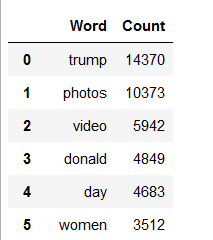
Néanmoins, après avoir codé un lda, on se rend compte que certains mots sureprésentés faussent la qualité du dataset, c'est pour cela que nous les retirons de la listes des noms pour les ajouter manuellement aux stopwords, cela améliore de beaucoup la qualité des métriques:
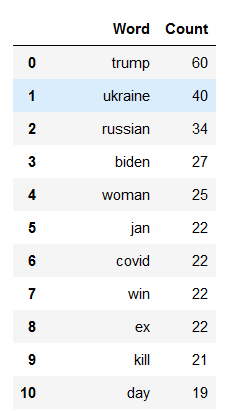
Nous obtenons donc une liste de noms communs dans le comptage des mots les plus fréquents de notre dataset:
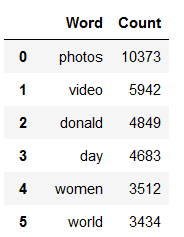

Etant donné que nous n'avons que des textes courts, nous mettons en place un système de bi-gram afin de creer plus de liens entre les mots et eviter les redondances. Nous étiquetons ensuite nos mots lors de la lemmatisation afin de pouvoir les identifier comme ayant des genres différents. Cette étape sera utile dans la mise en place de méthodologies. Après cette étape, nous voyons que l'occurence des mots change :
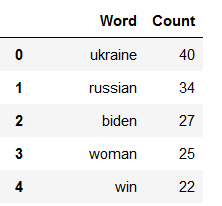

### 2) Choix de méthologies

Pour les méthodologies, dans un premier temps nous avons choisi un LDA ou Latent Dirichlet Allocation. Cette méthode est une méthode basée sur des probabiltés permettant d'expliquer un ensemble d'observations. Il s'agit bien d'apprentissage non-supervisé car ces explications sont réalisées sur des groupes non observés simplement définis par des similarités de données. Cette méthode est utile pour la détection de thématiques dans un sujet. En fait, cette méthode attribue une probabilté à un mot d'appartenir à un thème donné ou non, c'est comme ça que l'on peut sortir différentes thématiques et classer les documents selon celle qui ressort le plus de son analyse. 
Le seul problème de cette méthode est le fait qu'elle fonctionne mieux sur des textes assez long, ce qui n'est pas forcément le cas ici. Néanmoins, nous voulons tester la performance entre différentes méthodes, il faut donc voir la différence entre une méthode un peu moins adaptée et une qui l'est plus. 

Ce qui est aussi un plus avec la méthode du LDA est le fait qu'il y a plusieures métriques différentes qui permettent de savoir l'efficacité ou la précision de l'analyse, ce qui nous aiderait énormement lors de la comparaison avec d'autres méthodes.

La méthode des LDA a donc ses plus et ses moins mais elle semble être adaptée à ce que l'on recherche dans notre sujet.

### Premier modèle

#### Exécution du LDA

In [27]:
dictionary = gensim.corpora.Dictionary(l_texts)
dictionary.filter_extremes(no_below=15, no_above=0.1, keep_n=1000)
bow_corpus = [dictionary.doc2bow(doc) for doc in l_texts]

In [28]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics = 10, id2word = dictionary, passes = 1000)

In [29]:
topics = []
for idx, topic in lda_model.print_topics(-1) :
    print("Topic: {} -> Words: {}".format(idx, topic))
    topics.append(topic) 

Topic: 0 -> Words: 0.929*"covid" + 0.004*"biden" + 0.004*"official" + 0.004*"report" + 0.004*"abortion" + 0.004*"kill" + 0.004*"supreme_court" + 0.004*"ukraine" + 0.004*"attack" + 0.004*"time"
Topic: 1 -> Words: 0.493*"woman" + 0.468*"day" + 0.002*"twitter" + 0.002*"russian" + 0.002*"die" + 0.002*"ukraine" + 0.002*"police" + 0.002*"win" + 0.002*"abortion" + 0.002*"kill"
Topic: 2 -> Words: 0.682*"ukraine" + 0.291*"twitter" + 0.002*"russian" + 0.002*"attack" + 0.002*"biden" + 0.002*"day" + 0.002*"woman" + 0.002*"kill" + 0.002*"official" + 0.002*"time"
Topic: 3 -> Words: 0.529*"win" + 0.433*"time" + 0.002*"report" + 0.002*"supreme_court" + 0.002*"die" + 0.002*"day" + 0.002*"attack" + 0.002*"abortion" + 0.002*"ukraine" + 0.002*"kill"
Topic: 4 -> Words: 0.476*"police" + 0.476*"attack" + 0.003*"report" + 0.003*"kill" + 0.003*"ukraine" + 0.003*"twitter" + 0.003*"time" + 0.003*"day" + 0.003*"russian" + 0.003*"woman"
Topic: 5 -> Words: 0.492*"abortion" + 0.466*"die" + 0.003*"biden" + 0.003*"day

In [30]:
#Pour un bon modèle LDA la cohérence doit être comprise entre 0.4 et 0.7 au-delà et en dessous le modèle est très probablement erroné.
coherence_model_lda = CoherenceModel(model=lda_model, texts=l_texts, dictionary=dictionary)
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.6271063328057874


In [31]:
all_topic_model = []
for i in range(len(topics)):
  str = topics[i].split(' + ')
  topic_model = []
  for j in range(10):
    weight = str[j][0:5]
    word = str[j][7:len(str[j])-1]
    topic_model.append((weight, word))
  all_topic_model.append(topic_model)

In [32]:
df_topic_model = pd.DataFrame(all_topic_model)
df_topic_model.rename(index = {0: "Topic 1", 1: "Topic 2", 2: "Topic 3", 3: "Topic 4", 4: "Topic 5", 5: "Topic 6", 6: "Topic 7", 7: "Topic 8", 8: "Topic 9", 9: "Topic 10"})

,0,1,2,3,4,5,6,7,8,9
Topic 1,"(0.929, covid)","(0.004, biden)","(0.004, official)","(0.004, report)","(0.004, abortion)","(0.004, kill)","(0.004, supreme_court)","(0.004, ukraine)","(0.004, attack)","(0.004, time)"
Topic 2,"(0.493, woman)","(0.468, day)","(0.002, twitter)","(0.002, russian)","(0.002, die)","(0.002, ukraine)","(0.002, police)","(0.002, win)","(0.002, abortion)","(0.002, kill)"
Topic 3,"(0.682, ukraine)","(0.291, twitter)","(0.002, russian)","(0.002, attack)","(0.002, biden)","(0.002, day)","(0.002, woman)","(0.002, kill)","(0.002, official)","(0.002, time)"
Topic 4,"(0.529, win)","(0.433, time)","(0.002, report)","(0.002, supreme_court)","(0.002, die)","(0.002, day)","(0.002, attack)","(0.002, abortion)","(0.002, ukraine)","(0.002, kill)"
Topic 5,"(0.476, police)","(0.476, attack)","(0.003, report)","(0.003, kill)","(0.003, ukraine)","(0.003, twitter)","(0.003, time)","(0.003, day)","(0.003, russian)","(0.003, woman)"
Topic 6,"(0.492, abortion)","(0.466, die)","(0.003, biden)","(0.003, day)","(0.003, report)","(0.003, supreme_court)","(0.003, time)","(0.003, win)","(0.003, russian)","(0.003, kill)"
Topic 7,"(0.918, official)","(0.005, ukraine)","(0.005, kill)","(0.005, covid)","(0.005, russian)","(0.005, report)","(0.005, supreme_court)","(0.005, biden)","(0.005, abortion)","(0.005, attack)"
Topic 8,"(0.718, funniest_tweet)","(0.214, woman)","(0.004, official)","(0.004, time)","(0.004, abortion)","(0.004, kill)","(0.004, supreme_court)","(0.004, ukraine)","(0.004, attack)","(0.004, covid)"
Topic 9,"(0.600, russian)","(0.371, kill)","(0.002, ukraine)","(0.002, report)","(0.002, biden)","(0.002, day)","(0.002, police)","(0.002, official)","(0.002, die)","(0.002, attack)"
Topic 10,"(0.425, biden)","(0.284, supreme_court)","(0.268, report)","(0.002, abortion)","(0.002, russian)","(0.002, win)","(0.002, police)","(0.002, ukraine)","(0.002, kill)","(0.002, covid)"


In [33]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, dictionary)

C:\Users\sandr\anaconda\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.090754  0.115244       1        1  13.325966
2      0.101080 -0.407735       2        1  12.992639
8      0.099019  0.175753       3        1  12.702596
3      0.084554  0.031161       4        1  10.014286
1     -0.350466 -0.007114       5        1   9.927686
5      0.081089  0.028480       6        1   9.646322
4      0.074826  0.025275       7        1   9.105198
7     -0.317495 -0.003528       8        1   7.719934
0      0.071498  0.021596       9        1   7.416885
6      0.065141  0.020868      10        1   7.148488, topic_info=              Term       Freq      Total Category  logprob  loglift
0            covid  27.000000  27.000000  Default  18.0000  18.0000
11        official  26.000000  26.000000  Default  17.0000  17.0000
13         ukraine  35.000000  35.000000  Default  16.0000  16.0000
6          russian  30.000000  30.000000  Default  15.0000  15.0000
1   funniest_tweet  22.000000  22.000000  Default  14.0000  14.0000
..             ...        ...        ...      ...      ...      ...
5            biden   0.132316  22.726256  Topic10  -5.3375  -2.5078
2            woman   0.132316  25.994317  Topic10  -5.3375  -2.6422
0            covid   0.132318  27.409485  Topic10  -5.3375  -2.6952
6          russian   0.132317  30.288235  Topic10  -5.3375  -2.7950
13         ukraine   0.132324  35.042463  Topic10  -5.3375  -2.9408

[198 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
16        6  0.937480        abortion
12        7  0.965460          attack
5         1  0.968043           biden
0         9  0.985060           covid
3         5  0.956763             day
7         6  0.931852             die
1         8  0.944083  funniest_tweet
15        3  0.942646            kill
11       10  0.955873        official
4         7  0.965460          police
10        1  0.953372          report
6         3  0.957467         russian
14        1  0.968437   supreme_court
8         4  0.964991            time
17        2  0.969233         twitter
13        2  0.970251         ukraine
9         4  0.938693             win
2         5  0.730929           woman
2         8  0.230820           woman, R=18, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 3, 9, 4, 2, 6, 5, 8, 1, 7])

### Second modèle

#### LSA

In [27]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer

In [28]:
# add clean version to dataframe
dataset['clean_headline'] = texts

In [29]:
# vectorizing
vectorizer = TfidfVectorizer(max_features= 10000, max_df = 0.5, smooth_idf=True)
X = vectorizer.fit_transform(dataset['clean_headline'])
X.shape

(209527, 10000)

In [30]:
# create model with 42 topics
svd_model = TruncatedSVD(n_components=42, algorithm='randomized', n_iter=100, random_state=122)
svd_model.fit_transform(X)
len(svd_model.components_)

42

In [31]:
labels = dataset.category.unique()
print('number of topic : ', labels.size)

number of topic :  42


In [32]:
# dict for labels
labels_dict ={}
nb = 0
for i in labels:
    if i not in labels_dict :
        labels_dict[i] = nb
        nb = nb +1

print(labels_dict)

dataset['category_id'] = dataset['category'].apply(lambda x: labels_dict[x])
dataset.head()

{'U.S. NEWS': 0, 'COMEDY': 1, 'PARENTING': 2, 'WORLD NEWS': 3, 'CULTURE & ARTS': 4, 'TECH': 5, 'SPORTS': 6, 'ENTERTAINMENT': 7, 'POLITICS': 8, 'WEIRD NEWS': 9, 'ENVIRONMENT': 10, 'EDUCATION': 11, 'CRIME': 12, 'SCIENCE': 13, 'WELLNESS': 14, 'BUSINESS': 15, 'STYLE & BEAUTY': 16, 'FOOD & DRINK': 17, 'MEDIA': 18, 'QUEER VOICES': 19, 'HOME & LIVING': 20, 'WOMEN': 21, 'BLACK VOICES': 22, 'TRAVEL': 23, 'MONEY': 24, 'RELIGION': 25, 'LATINO VOICES': 26, 'IMPACT': 27, 'WEDDINGS': 28, 'COLLEGE': 29, 'PARENTS': 30, 'ARTS & CULTURE': 31, 'STYLE': 32, 'GREEN': 33, 'TASTE': 34, 'HEALTHY LIVING': 35, 'THE WORLDPOST': 36, 'GOOD NEWS': 37, 'WORLDPOST': 38, 'FIFTY': 39, 'ARTS': 40, 'DIVORCE': 41}


,link,headline,category,short_description,authors,date,clean_headline,category_id
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23,million americans roll sleeves omicron targete...,0
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23,american_airlines flyer charged banned life pu...,0
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23,funniest_tweets cats_dogs week sept,1
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23,funniest_tweets parents_week sept,2
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22,woman called cops black bird watcher loses law...,0


In [34]:
# show most recurent word for each topic
terms = vectorizer.get_feature_names_out()

for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    print("Topic "+str(i)+": ")
    for t in sorted_terms:
        print(t[0])
        print(" ")

Topic 0: 
photos
 
world
 
video
 
week
 
day
 
home
 
recipes
 
Topic 1: 
donald
 
video
 
love
 
women
 
life
 
time
 
kids
 
Topic 2: 
donald
 
photos
 
hillary_clinton
 
president
 
gop
 
stephen_colbert
 
america
 
Topic 3: 
love
 
life
 
don
 
reasons
 
kids
 
women
 
people
 
Topic 4: 
world
 
women
 
day
 
time
 
life
 
week
 
funniest_tweets
 
Topic 5: 
life
 
time
 
kids
 
photos
 
change
 
divorce
 
living
 
Topic 6: 
women
 
week
 
funniest_tweets
 
don
 
black
 
health
 
photos
 
Topic 7: 
time
 
kids
 
people
 
love
 
parents
 
don
 
mom
 
Topic 8: 
kids
 
day
 
don
 
parents
 
people
 
school
 
wedding
 
Topic 9: 
day
 
wedding
 
look
 
love
 
time
 
national
 
st_patrick
 
Topic 10: 
people
 
don
 
america
 
black
 
white
 
help
 
food
 
Topic 11: 
america
 
kids
 
food
 
black
 
obama
 
cities
 
wall_st
 
Topic 12: 
don
 
america
 
look
 
wedding
 
americans
 
care
 
republicans
 
Topic 13: 
week
 
don
 
kids
 
funniest_tweets
 
people
 
animal_photos
 
video
 
Topic 1

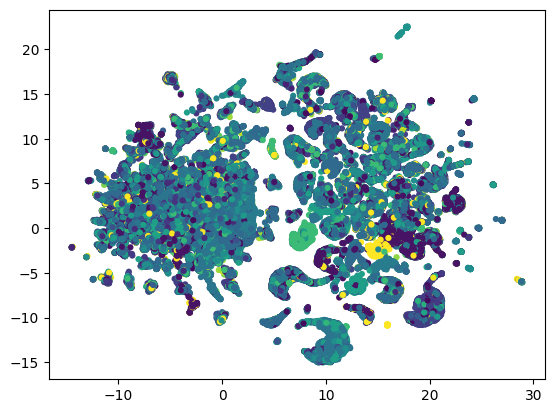

In [44]:
# show cluster
X_topics = svd_model.fit_transform(X)
embedding = umap.UMAP(n_neighbors=150, min_dist=0.5, random_state=12).fit_transform(X_topics)

plt.scatter(embedding[:, 0], embedding[:, 1],
s = 20, c=dataset['category_id'],
edgecolor='none')
plt.show()

Ce graphe nous montre les clusters du dataset avec les 42 groupes, nous remarquons que la sépartion des clusters ne sont pas bien distinct (mauvais résultat). Nous pouvons en déduire que LSA n'est pas efficace sur un grand dataset malgré son avantage de puissance de calcul.

*Conclusion de la partie des méthodes* :

Nous voyons ici les dix topics différents. Nous remarquons que seuls 3 "grands topics" se distinguent. Certains topics établis sont en réalité un sous-ensemble de topics plus généraux. Néanmoins, des variations font que chacun des topics identifiés sont bien uniques. 
Nous remarquons que le thème le plus traité est celui de l'ukraine car il s'agit des actualités mondiales. Un autre thème est celui des actualités aux US et le dernier thème est un peu plus généraliste avec les femmes et twitter.

Néanmoins, même si cette méthode n'est pas la plus efficace, elle reste tout de même un bon modèle car nous obtenons bien des topics différents et cohérents.

### 3) Métriques

### Explications

 - Pour la métrique du LDA, la "coherence_lda" permet d'évaluer le dégré de similitude sémantique entre les mots au plus haut pourcentage des topics. Cette mesure permet de faire la distinction entre les topics interprétables indépendamment et ceux dû a des problèmes statistiques. Pour un bon modèle LDA, la cohérence doit etre comprise entre 0.4 et 0.7. Si la cohérence obtenues est supérieure à 0.7 ou inférieure à 0.4 alors le modèle est erroné.
 - La seconde métrique du LDA que l'on peut analyser est la "perplexity". Cette mesure permet de savoir a quel point le modèle réalisé est un bon modele. Il faut noter que plus le chiffre est bas, plus le modèle est bon.
 - Une autre métrique du LDA pourrait etre le poids minimum du sous-sujet le plus représentatif du topic. On peut suggérer qu'un poids en dessous de 0.5 veut dire que le sujet est bien représentatif du topic créé ou du moins est le sujet majeur de cette section. On peut également avoir des sujets liés à un autre sujet par exemple "russian" peut etre lié à "war" ou "covid", cela dépend du sujet traité par le journal. Nous pouvons alors également prendre en compte le poids du second sujet le plus représenté dans un topic. Si les deux poids sont supérieurs à 0.8 soit 80 % du sujet traité alors on peut établir que le sujet traité dans le topic selon notre code est bien celui réellement traité par le journal. Il peut servir à évaluer la qualité des conclusions fournies.

### Calculs et résultats

In [34]:
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.6271063328057874


Nous avons bien un coherence score de 0.62 compris entre 0.4 et 0.8. Nous pouvons affirmer que le modèle est valide.

In [35]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(bow_corpus))


Perplexity:  -3.2893873353569782


Nous avons un score de -3.28 environ, ce score étant en dessous de zéro, nous pouvons penser qu'il s'agit d'un bon score. Nous estimons donc que le modèle réalisé est d'assez bonne qualité.

In [36]:
df_topic_model[0]

0             (0.929, covid)
1             (0.493, woman)
2           (0.682, ukraine)
3               (0.529, win)
4            (0.476, police)
5          (0.492, abortion)
6          (0.918, official)
7    (0.718, funniest_tweet)
8           (0.600, russian)
9             (0.425, biden)
Name: 0, dtype: object

Si l'on se fie à notre première métrique de 0.5 de poids, seuls les topics 2,4, 5 et 9 ne dépassent pas les 50 % d'influence sur le poids du topic. Regardons si l'addition des 2 premiers poids est supérieur à 0.8 pour savoir s'il s'agit d'un sujet composé.

In [37]:
df_topic_model[1]

0            (0.004, biden)
1              (0.468, day)
2          (0.291, twitter)
3             (0.433, time)
4           (0.476, attack)
5              (0.466, die)
6          (0.005, ukraine)
7            (0.214, woman)
8             (0.371, kill)
9    (0.284, supreme_court)
Name: 1, dtype: object

Pour le topic 2, cela donne 0.493 + 0.468 = 0.961, il s'agit donc bien d'un sujet composé sur le thème du covid et biden. Pour le thème 4, cela donne 0.476 +.0.476 = 0.952, il s'agit également d'un sujet composé sur le thème de la police et des attaques. Pour les 2 autres topics, nous nous trouvons également au dessus de 0.8 avec pour le topic 5 un score de 0.958 et pour le topic 9 c'est 0.977 en prenant les 3 premiers. Etant donné que nous avons réussi l'ensemble des tests proposés, nous pouvons dire que le test de qualité des tests est correcte et ils peuvent etre exploités.

#### En testant avec les catégories des textes

In [39]:
splitted_texts2 = dummy_word_split(dataset["category"].tolist())
splitted_texts2

[['U.S.', 'NEWS'],
 ['U.S.', 'NEWS'],
 ['COMEDY'],
 ['PARENTING'],
 ['U.S.', 'NEWS'],
 ['U.S.', 'NEWS'],
 ['U.S.', 'NEWS'],
 ['WORLD', 'NEWS'],
 ['CULTURE', '&', 'ARTS'],
 ['WORLD', 'NEWS'],
 ['WORLD', 'NEWS'],
 ['WORLD', 'NEWS'],
 ['WORLD', 'NEWS'],
 ['TECH'],
 ['U.S.', 'NEWS'],
 ['WORLD', 'NEWS'],
 ['CULTURE', '&', 'ARTS'],
 ['SPORTS'],
 ['WORLD', 'NEWS'],
 ['WORLD', 'NEWS'],
 ['ENTERTAINMENT'],
 ['POLITICS'],
 ['WORLD', 'NEWS'],
 ['U.S.', 'NEWS'],
 ['POLITICS'],
 ['U.S.', 'NEWS'],
 ['SPORTS'],
 ['WORLD', 'NEWS'],
 ['ENTERTAINMENT'],
 ['WEIRD', 'NEWS'],
 ['POLITICS'],
 ['U.S.', 'NEWS'],
 ['ENVIRONMENT'],
 ['WORLD', 'NEWS'],
 ['ENVIRONMENT'],
 ['ENVIRONMENT'],
 ['WORLD', 'NEWS'],
 ['ENVIRONMENT'],
 ['WEIRD', 'NEWS'],
 ['ENTERTAINMENT'],
 ['POLITICS'],
 ['U.S.', 'NEWS'],
 ['U.S.', 'NEWS'],
 ['ENTERTAINMENT'],
 ['POLITICS'],
 ['CULTURE', '&', 'ARTS'],
 ['U.S.', 'NEWS'],
 ['ENTERTAINMENT'],
 ['ENTERTAINMENT'],
 ['ENTERTAINMENT'],
 ['ENTERTAINMENT'],
 ['WORLD', 'NEWS'],
 ['ENTERTAINMENT']

In [40]:
splitted_texts2 = np.unique(splitted_texts2)
compute_word_occurences(splitted_texts2)

C:\Users\sandr\anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


,Word,Count
0,&,5
1,NEWS,4
2,ARTS,3
3,VOICES,3
4,CULTURE,2
5,LIVING,2
6,WORLDPOST,2
7,STYLE,2
8,BEAUTY,1
9,POLITICS,1


Pour la métrique du LSA : on veut une variance inter grande et une variance intra faible pour avoir des clusters bien séparés. Nous devrions donc voir un cluster indépendant par topic or ici l'ensemble des clusters sont mélangés. Les métriques ici sont donc les variances et elles ne sont pas de bonnes qualités car nous n'avons pas de cluster bien séparés. De plus, on peut remarquer qu'au sein de chaque cluster, les observations sont homgènes.

### 4) Comparaisons

Le LSA se focalise sur la réduction des dimensions de matrice tandis que LDA résout les problèmes de topic modeling. LDA est plus avantageuse pour un gros datset avec de classes multiples et elle est utilisée pour des analyses de données au vue des graphes réalisables de ce dernier.

### 5) Conclusion

Le LDA a plus de metriques que l'on peut utiliser à des fins de comparaisons et d'analyses. De même, la méthode LDA permet d'avoir des graphiques plus visuels et compréhensibles que ceux obtenus avec LSA.  Néanmoins, le LSA permet  de réduire la matrice de dimension, ce qui permet d'avoir un temps de calcul réduit et donc de meilleures performances.
Avec notre dataset et les méthodes que l'on a utilisées, c'est le LDA qui semble être le plus efficace dans la modélisation de topics. En effet, nos métriques pour le LDA respectent les seuils que nous avons décidé ou qui sont données dans la documentation associée. Son score de cohérence et de perplexité sont tout les deux considérés comme bons et attestent d'un modèle de qualité. Aussi, d'après la partie 4, nous savons que le LDA est vraiment spécialisé dans la résolution de problèmes de topics modeling.
Comme il s'agit d'une étude sur de gros dataset, il est évident d'utiliser LDA pour notre cas.